This used latent space of 1024 and hidden of only 512. But it seems to really struggle because of the smaller hidden space.
    

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from world_models_sonic.models.vae import VAE6, loss_function_vae
from world_models_sonic.helpers.summarize import TorchSummarizeDf
from world_models_sonic.helpers.dataset import load_cache_data
from world_models_sonic.models.rnn import MDNRNN2
from world_models_sonic.models.inverse_model import InverseModel
from world_models_sonic.models.world_model import WorldModel
from world_models_sonic.custom_envs.wrappers import discrete_actions
from world_models_sonic import config
len(discrete_actions)

10

# Init

In [4]:
cuda= torch.cuda.is_available()
env_name='sonic256'
num_epochs=200
batch_size = 1

# VAE loss function
lambda_vae_kld = 0.25
C = 0
z_dim = 256 # latent dimensions

# RNN
action_dim = 10
seq_len = 8
image_size=256
chunksize=seq_len*20



# loss function weights
lambda_vae = 1/20
lambda_finv = 1

data_cache_file = os.path.join(config.base_vae_data_dir, 'sonic_rnn_256_v30.hdf5')
NAME='RNN_v3b_256im_512z_v6_greenfield'

In [5]:
if not os.path.isdir('./outputs/{NAME}'.format(NAME=NAME)):
    os.makedirs('./outputs/{NAME}'.format(NAME=NAME))
    
data_cache_file = os.path.join(config.data_cache_dir, 'sonic_rnn_256_v31.hdf5')
history_file = './outputs/{NAME}/history.csv'.format(NAME=NAME)
save_file_rnn = './outputs/{NAME}/mdnrnn_state_dict.pkl'.format(NAME=NAME)
save_file_vae = './outputs/{NAME}/vae_state_dict.pkl'.format(NAME=NAME)
save_file_finv = './outputs/{NAME}/finv_state_dict.pkl'.format(NAME=NAME)

# Load Data

In [6]:
loader_train, loader_test = load_cache_data(
    basedir=config.base_vae_data_dir, 
    env_name=env_name, 
    data_cache_file=data_cache_file, 
    image_size=image_size, 
    chunksize=chunksize, 
    action_dim=action_dim,
    batch_size=batch_size,
    seq_len=seq_len,
)
loader_train, loader_test
len(loader_train.dataset), len(loader_test.dataset)

<zarr.core.Array (50400, 256, 256, 3) uint8 read-only> <zarr.core.Array (50400,) uint8 read-only> <zarr.core.Array (50400,) uint8 read-only> <zarr.core.Array (50400,) float32 read-only>


/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



Loaded from cache /MLDATA/sonic/vae/sonic_rnn_256_v31.hdf5


(40320, 10080)

# Load VAE

In [8]:
# Load VAE
# TODO swap z and k dim, since it's inconsistent with other models
vae = VAE6(image_size=image_size, z_dim=32, conv_dim=48, code_dim=8, k_dim=z_dim)
if cuda:
    vae.cuda()
    
# # Resume
if os.path.isfile(save_file_vae):
    state_dict = torch.load(save_file_vae)
    vae.load_state_dict(state_dict)
    print('loaded save_file {save_file_vae}'.format(save_file_vae=save_file_vae))

loaded save_file ./outputs/RNN_v3b_256im_512z_v6_greenfield/vae_state_dict.pkl


# Load RNN

In [10]:
# Load MDRNN
action_dim, hidden_size, n_mixture, temp = action_dim, 128, 3, 0.0


mdnrnn = MDNRNN2(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()
    
# # Resume
if os.path.isfile(save_file_rnn):
    state_dict = torch.load(save_file_rnn)
    mdnrnn.load_state_dict(state_dict)
    print('loaded {save_file}'.format(save_file=save_file_rnn))

loaded ./outputs/RNN_v3b_256im_512z_v6_greenfield/mdnrnn_state_dict.pkl


# Load inverse model

In [11]:
finv = InverseModel(z_dim, action_dim, hidden_size=256).cuda()

# Resume
if os.path.isfile(save_file_finv):
    state_dict = torch.load(save_file_finv)
    finv.load_state_dict(state_dict)
    print('loaded {save_file_finv}'.format(save_file_finv=save_file_finv))

loaded ./outputs/RNN_v3b_256im_512z_v6_greenfield/finv_state_dict.pkl


# Init

In [12]:
model = WorldModel(vae, mdnrnn, finv)
model

WorldModel(
  (vae): VAE6(
    (logvar): Linear(in_features=2048, out_features=256, bias=True)
    (mu): Linear(in_features=2048, out_features=256, bias=True)
    (z): Linear(in_features=256, out_features=2048, bias=True)
    (encoder): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.01, inplace)
      )
      (1): ConvBlock5(
        (conv0): InceptionA(
          (branch1x1): BasicConv2d(
            (conv): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): LeakyReLU(negative_slope=0.01, inplace)
          )
          (branch5x5_1): BasicConv2d(
            (conv): Conv2d(48, 9, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(9, eps=1e-05, momentum=0.

# Train helpers

In [13]:
# Plot reconstructions
def plot_results(loader, n=2, epoch=0, figsize=(9,6)):
    with torch.no_grad():
        vae.eval()
        mdnrnn.eval()

        observations, actions, rewars, dones = next(iter(loader))

        X = Variable(observations.transpose(1,3))
        _, channels, height, width = X.size()
        if cuda:
            X=X.cuda()
        Y, mu_vae, logvar = vae.forward(X)
        loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
        loss_vae = loss_recon + lambda_vae_kld * torch.abs(loss_KLD-C)

        # TODO do we want to sample in test or training mode?
        z_v = vae.sample(mu_vae, logvar)

        z_v = z_v.view(batch_size, seq_len, -1)
        Y = Y.view((batch_size, seq_len, channels, height, width))
        X = X.view((batch_size, seq_len, channels, height, width))
        loss_vae = loss_vae.view(batch_size, seq_len)
        actions = actions.view(batch_size, seq_len)

        # Forward
        actions_v = Variable(actions).float()


        if cuda:
            z_v=z_v.cuda()
            actions_v=actions_v.cuda()
        pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)
        z_true_next = z_v[:,1:]
        loss_mdn_rnn = mdnrnn.rnn_loss(z_true_next, pi[:,:-1], mu[:,:-1], sigma[:,:-1])

        mu2 = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
        X_pred = vae.decode(mu2)
        X_pred = X_pred.view((batch_size, seq_len, channels, height, width))

        # Finv forward
        z_next_pred = mdnrnn.sample(pi, mu, sigma)
        action_pred = finv(z_v[:,1:], z_next_pred[:,:-1]).float()

        actions_v_hot = torch.eye(action_dim)[actions_v.long()].cuda()
        loss_inv = F.binary_cross_entropy_with_logits(action_pred, actions_v_hot[:,1:])
        action_pred_int = action_pred.max(-1)[1]
        print(action_pred_int)

        loss = loss_vae.mean(1) + loss_mdn_rnn.mean(1) + loss_inv.mean()

        for i in np.linspace(0,seq_len-2,n):
            batch = np.random.randint(0,batch_size)
            i=int(i)
            y=Y[batch][i].cpu().data.transpose(0,2).numpy()
            x_orig = X[batch][i].transpose(0,2).data.cpu().numpy()
            x_next = X[batch][i+1].transpose(0,2).data.cpu().numpy()
            x_pred = X_pred[batch][i].transpose(0,2).data.cpu().numpy()
            loss_vae_i = loss_vae[batch][i].cpu().data.item()
            loss_mdnrnn_i = loss_mdn_rnn[batch][i].cpu().data.item()
            loss_inv_i = loss_inv.cpu().data.item()
            loss_i = loss[batch].cpu().data.item()

            print('action_pred', action_pred_int[batch][i].data.cpu().item())
            print('action_true', actions_v[:,1:][batch][i].data.cpu().item())
            print('finv loss {:2.4f}'.format(loss_inv_i))

            plt.figure(figsize=figsize)

            plt.subplot(2, 3, 1)
            plt.axis("off")
            plt.title('original')
            plt.imshow(x_orig)

            plt.subplot(2, 3, 4)
            plt.axis("off")
            plt.imshow(y)
            plt.title('reconstructed \nloss_vae={:2.4f}'.format(loss_vae_i))

            plt.subplot(2, 3, 2)
            plt.axis("off")
            plt.imshow(x_next)
            plt.title('true next')

            plt.subplot(2, 3, 5)
            plt.axis("off")
            plt.imshow(x_pred)
            plt.title('pred next \nloss_mdnrnn={:2.4f}'.format(loss_mdnrnn_i))

            plt.subplot(2, 3, 3)
            plt.axis("off")
            plt.imshow(np.abs(x_orig-x_next))
            plt.title('actual changes')

            plt.subplot(2, 3, 6)
            plt.axis("off")
            plt.imshow(np.abs(y[i]-x_pred))
            plt.title('predicted changes')

            plt.suptitle('epoch {}, seq index {}, batch={}. loss {:2.4f}'.format(
                epoch, 
                i,
                batch,
                loss_i
            ))
    #         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
            plt.show()
        


In [14]:
import collections

def train(loader, vae, mdnrnn, optimizer, max_batches=None, test=False, cuda=True, joint_training=False):
    vae.eval()
    if test:
        mdnrnn.eval()
    else:
        mdnrnn.train()
    info = collections.defaultdict(list)
    hidden_state = None
    if max_batches is None:
        max_batches = len(loader)
    else:
        max_batches = min(max_batches, len(loader))
    iterator = iter(loader)

    with tqdm(total=max_batches*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i in range(max_batches):
            # the loader batch_size is seq_len*batch_size
            # we put it through the VAE as (seq_len*batch_size,...)
            # then reshape to (batch_size,seq_len,...) for the mdnrnn
            observations, actions, rewards, dones = next(iterator)
            X = Variable(observations.transpose(1,3))
            if cuda:
                X=X.cuda()
                
            # VAE forward
            Y, mu_vae, logvar = vae.forward(X)
            
            loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
            loss_vae = loss_recon + lambda_vae_kld * torch.abs(loss_KLD-C)
            loss_vae = loss_vae.mean() # mean along the batches

            # MDNRNN Forward
            z_v = vae.sample(mu_vae, logvar)
            z_v = z_v.view(batch_size, seq_len, -1)
            actions_v = Variable(actions).float()
            actions_v = actions_v.view(batch_size, seq_len)
            if cuda:
                z_v=z_v.cuda()
                actions_v=actions_v.cuda()
            pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

            # We are evaluating how the output distribution for the next step
            # matches the real next step. So we have to discard the last step in the 
            # sequence which has no next step.
            z_true_next = z_v[:,1:]
            loss_mdn = mdnrnn.rnn_loss(z_true_next, pi[:,:-1], mu[:,:-1], sigma[:,:-1]).mean()
            
            # Finv forward
            z_next_pred = mdnrnn.sample(pi, mu, sigma)
            action_pred = finv(z_v[:,1:], z_next_pred[:,:-1]).float()
            actions_v_hot = torch.eye(action_dim)[actions_v.long()].cuda()
            loss_inv = F.binary_cross_entropy_with_logits(action_pred, actions_v_hot[:,1:])
            loss_inv = loss_inv.mean()
            
            loss = loss_mdn + lambda_finv * loss_inv + lambda_vae * loss_vae

            if not test:
                loss.backward()
                optimizer.step()
            optimizer.zero_grad()

            # Record
            info['loss_inv'].append(loss_inv.cpu().data.numpy())
            info['loss_mdn'].append(loss_mdn.cpu().data.numpy())
            info['loss_vae'].append(loss_vae.cpu().data.numpy())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            prog.update(loader.batch_size)
            prog.desc='loss={loss:2.4f}, loss_rnn={loss_mdn:2.4f}, loss_inv= {loss_inv2:2.4f}={lambda_finv}* {loss_inv:2.4f}, loss_vae={loss_vae:2.4f}={lambda_vae:2.4f} * ({loss_recon:2.2f} + {lambda_vae_kld}*|{loss_KLD:2.2f} - {C}|)'.format(
                loss=loss.cpu().data.item(),
                loss_mdn=np.mean(info['loss_mdn']), 
                loss_recon=np.mean(info['loss_recon']),
                loss_KLD=np.mean(info['loss_KLD']),
                loss_vae=lambda_vae*(np.mean(info['loss_recon'])+lambda_vae_kld*(np.mean(info['loss_KLD'])-C)),
                loss_inv=np.mean(info['loss_inv']),
                loss_inv2=np.mean(info['loss_inv'])*lambda_finv,
                lambda_vae_kld=lambda_vae_kld,
                lambda_finv=lambda_finv,
                lambda_vae=lambda_vae,
                C=C
            )
            if i%400==0:
                print('[{}/{}]'.format(i, max_batches), prog.desc)

        print(prog.desc)
        prog.close()

    return info

# Train

In [15]:
import torch.optim.lr_scheduler
torch.cuda.empty_cache()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, verbose=True)
max_batches=20000//loader_train.batch_size
max_batches

2500

In [16]:
# Load previous history
import pandas as pd
if os.path.isfile(history_file):
    try:
        histories = pd.read_csv(history_file).to_dict(orient='records')
    except pd.errors.EmptyDataError:
        histories = []
else:
    histories = []

In [19]:
for epoch in range(num_epochs):
    # Run
    info = train(loader_train, vae, mdnrnn, optimizer, max_batches=max_batches, test=False, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    info_val = train(loader_test, vae, mdnrnn, optimizer, max_batches=max_batches//6, test=True, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    
    # Adjust
    scheduler.step(np.mean(info_val['loss_mdn']))
    
    # View
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}, loss_vae={:2.4f}, loss_vae_val={:2.4f},  loss_finv={:2.4f}, loss_finv_vae={:2.4f}, ,'.format(
        epoch, 
        np.mean(info['loss_mdn']), 
        np.mean(info_val['loss_mdn']),
        np.mean(info['loss_vae']), 
        np.mean(info_val['loss_vae']),
        np.mean(info['loss_finv']),
        np.mean(info_val['loss_finv'])
    ))
    plot_results(loader_test, n=2, epoch=epoch)
    
    # Record
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    
    torch.save(mdnrnn.state_dict(), './outputs/{NAME}/checkpoint_{epoch}_mdnrnn_state_dict.pkl'.format(NAME=NAME, epoch=epoch))
    torch.save(vae.state_dict(), './outputs/{NAME}/checkpoint_{epoch}_vae_state_dict.pkl'.format(NAME=NAME, epoch=epoch))
    torch.save(finv.state_dict(), './outputs/{NAME}/checkpoint_{epoch}_finv_state_dict.pkl'.format(NAME=NAME, epoch=epoch))
      
    # Tidy
    torch.cuda.empty_cache()

[0/2500] loss=270.5406, loss_rnn=16.8209, loss_inv= 0.7266=1* 0.7266, loss_vae=252.9931=0.0500 * (5058.32 + 0.25*|6.18 - 0|)


/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[400/2500] loss=325.8134, loss_rnn=16.5153, loss_inv= 0.7100=1* 0.7100, loss_vae=183.5955=0.0500 * (3669.25 + 0.25*|10.65 - 0|)
[800/2500] loss=273.7216, loss_rnn=16.6448, loss_inv= 0.7115=1* 0.7115, loss_vae=210.0252=0.0500 * (4198.27 + 0.25*|8.94 - 0|)
[1200/2500] loss=220.6727, loss_rnn=16.6404, loss_inv= 0.7111=1* 0.7111, loss_vae=207.2076=0.0500 * (4141.97 + 0.25*|8.71 - 0|)
[1600/2500] loss=377.2711, loss_rnn=16.6939, loss_inv= 0.7126=1* 0.7126, loss_vae=214.8679=0.0500 * (4295.33 + 0.25*|8.13 - 0|)
[2000/2500] loss=189.2558, loss_rnn=16.6824, loss_inv= 0.7132=1* 0.7132, loss_vae=215.1554=0.0500 * (4301.16 + 0.25*|7.78 - 0|)
[2400/2500] loss=476.6848, loss_rnn=16.6518, loss_inv= 0.7138=1* 0.7138, loss_vae=215.5356=0.0500 * (4308.89 + 0.25*|7.29 - 0|)
loss=292.6062, loss_rnn=16.6563, loss_inv= 0.7139=1* 0.7139, loss_vae=216.0022=0.0500 * (4318.21 + 0.25*|7.34 - 0|)



[0/416] loss=262.7585, loss_rnn=17.3972, loss_inv= 0.6980=1* 0.6980, loss_vae=244.6633=0.0500 * (4892.09 + 0.25*|4.69 - 0|)



RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/generic/THCStorage.cu:58

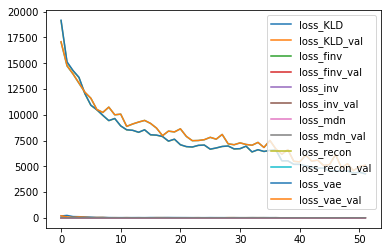

In [21]:
import pandas as pd
df_history = pd.DataFrame(histories)
df_history.plot()
df_history.to_csv(history_file, index=False)

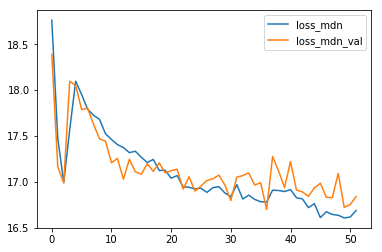

In [22]:
df_history[['loss_mdn','loss_mdn_val']].plot()

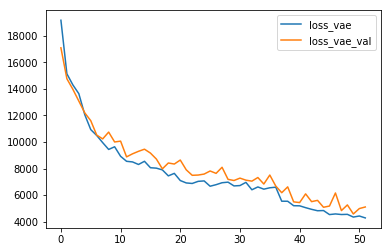

In [23]:
df_history[['loss_vae','loss_vae_val']].plot()

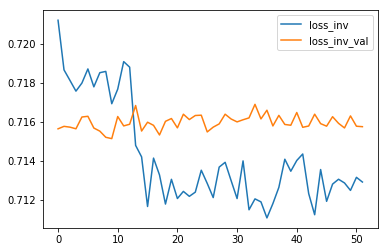

In [24]:
df_history[['loss_inv','loss_inv_val']].plot()

## Save

In [25]:
torch.save(mdnrnn.state_dict(), save_file_rnn)
torch.save(vae.state_dict(), save_file_vae)
torch.save(finv.state_dict(), save_file_finv)

## View

tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 2.0
finv loss 0.7195


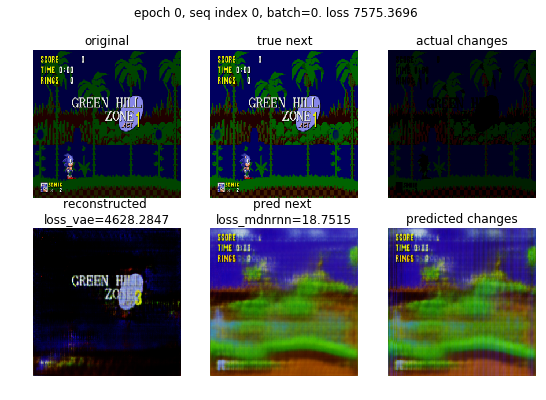

action_pred 2
action_true 5.0
finv loss 0.7195


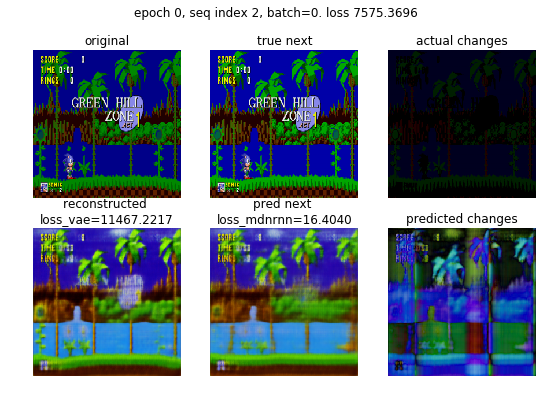

action_pred 2
action_true 0.0
finv loss 0.7195


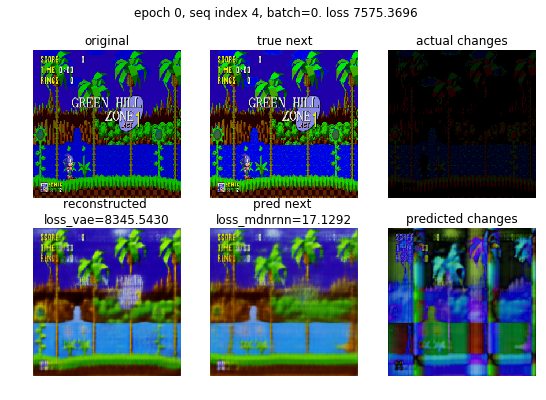

action_pred 2
action_true 2.0
finv loss 0.7195


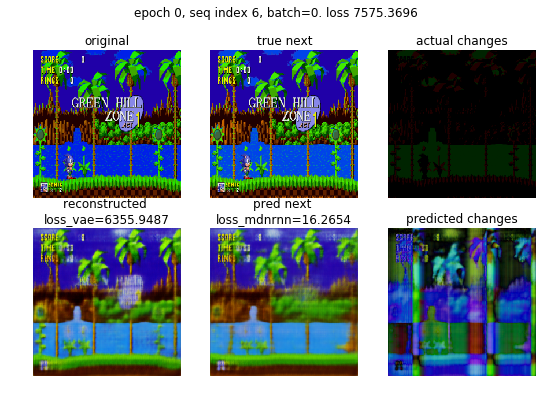

In [26]:
plot_results(loader_test, n=4, epoch=0)

tensor([[ 2,  2,  2,  2,  2,  2,  2]], device='cuda:0')
action_pred 2
action_true 2.0
finv loss 0.7123


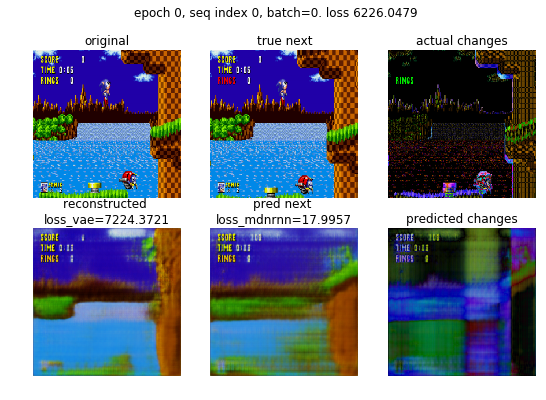

action_pred 2
action_true 6.0
finv loss 0.7123


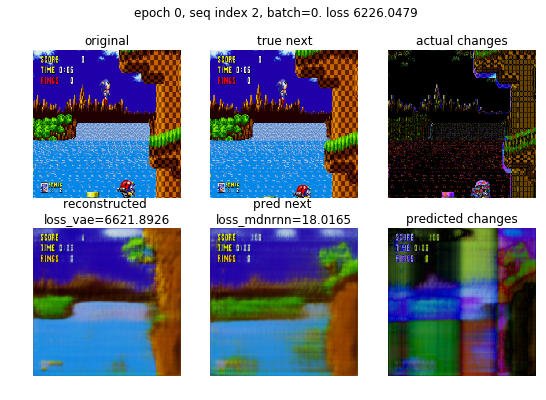

action_pred 2
action_true 5.0
finv loss 0.7123


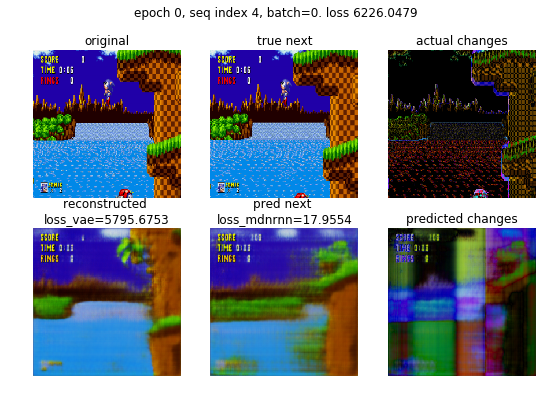

action_pred 2
action_true 2.0
finv loss 0.7123


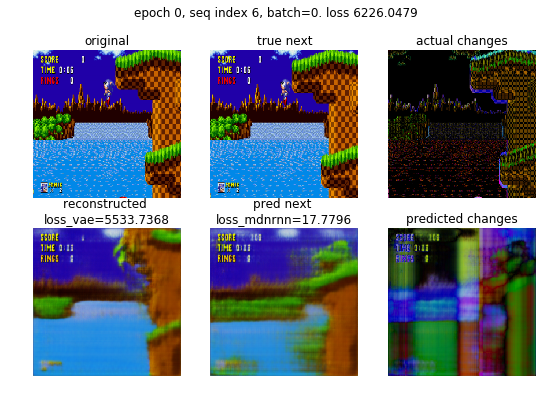

In [27]:
plot_results(loader_train, n=4, epoch=0)

In [28]:
torch.cuda.empty_cache()

# Summarize models

In [ ]:
from IPython.display import display
with torch.no_grad():
    img = np.random.randn(image_size, image_size, 3)
    action = np.array(np.random.randint(0,action_dim))[np.newaxis]
    action = Variable(torch.from_numpy(action)).float().cuda()[np.newaxis]
    gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
    if cuda:
        gpu_img = gpu_img.cuda()
    with TorchSummarizeDf(vae) as tdf:
        x, mu_vae, logvar_vae = vae.forward(gpu_img)
        z = vae.sample(mu_vae, logvar_vae)
        df_vae = tdf.make_df()

    display(df_vae[df_vae.level<2])
    
    with TorchSummarizeDf(mdnrnn) as tdf: 
        pi, mu, sigma, hidden_state = mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.repeat((1,2)))
        z_next = mdnrnn.sample(pi, mu, sigma)
        df_mdnrnn = tdf.make_df()
    
    display(df_mdnrnn)
    

    with TorchSummarizeDf(finv) as tdf:
        finv(z.repeat((1,2,1)), z_next)   
        df_finv = tdf.make_df()
    display(df_finv)

#     with TorchSummarizeDf(world_model) as tdf:
#         world_model(gpu_img, action)
#         df_world_model = tdf.make_df()
#     display(df_world_model[df_world_model.level<2])
    
    del img, action, gpu_img, x, mu, z, z_next, mu_vae, logvar_vae, pi, sigma

# DEBUG

In [ ]:
# DEBUG the distributions
vae.train()
mdnrnn.train()

observations, actions, rewards, dones = next(iter(loader_train))

X = Variable(observations.transpose(1,3))
_, channels, height, width = X.size()
if cuda:
    X=X.cuda()
Y, mu_vae, logvar = vae.forward(X)
loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
loss_vae = loss_recon + lambda_vae_kld * torch.abs(loss_KLD-C)

# TODO do we want to sample in test or training mode?
z_v = vae.sample(mu_vae, logvar)

z_v = z_v.view(batch_size, seq_len, -1)
Y = Y.view((batch_size, seq_len, channels, height, width))
X = X.view((batch_size, seq_len, channels, height, width))
loss_vae = loss_vae.view(batch_size, seq_len, -1)
actions = actions.view(batch_size, seq_len)

# Forward
actions_v = Variable(actions).float()


if cuda:
    z_v=z_v.cuda()
    actions_v=actions_v.cuda()
pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)

# mu = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
# X_pred = vae.decode(mu)
# X_pred = X_pred.view((batch_size, seq_len, channels, height, width))


mdnrnn.train()

zs=mdnrnn.sample(pi, mu, sigma)







z_v = vae.sample(mu_vae, logvar)
plt.hist(z_v.cpu().data.numpy().flatten(), bins=50)
plt.title('z_v')
plt.show()

plt.hist(zs.cpu().data.numpy().flatten(), bins=50)
plt.title('z_pred')
plt.show()

plt.hist(mu_vae.cpu().data.numpy().flatten(), bins=50)
plt.title('mu_vae')
plt.show()

plt.hist(mu.cpu().data.numpy().flatten(), bins=50)
plt.title('mu')
plt.show()

plt.hist(logvar.exp().cpu().data.numpy().flatten(), bins=50)
plt.title('sigma_vae')
plt.show()

plt.hist(sigma.cpu().data.numpy().flatten(), bins=50)
plt.title('sigma')
plt.show()
